In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import lightgbm
from sklearn.metrics import mean_squared_error
import warnings
import gc


warnings.filterwarnings('ignore')
np.random.seed(4590)

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
sales_train = pd.read_csv('/Users/sinsakuokazaki/Project/pred-future-sales/\
input/competitive-data-science-predict-future-sales/sales_train.csv')
item_categories = pd.read_csv('/Users/sinsakuokazaki/Project/pred-future-sales/\
input/competitive-data-science-predict-future-sales/item_categories.csv')

items = pd.read_csv('/Users/sinsakuokazaki/Project/pred-future-sales/\
input/competitive-data-science-predict-future-sales/items.csv')

shops = pd.read_csv('/Users/sinsakuokazaki/Project/pred-future-sales/\
input/competitive-data-science-predict-future-sales/shops.csv')

In [3]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,dayofweek,dayofmonth,month,quarter,year,minute,hour,total_sales,shop_name,item_name,item_category_id,item_category_name
0,2013-01-02,0,59,22154,999.00,1.0,2,2,1,1,2013,0,0,999.00,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,2013-01-03,0,25,2552,899.00,1.0,3,3,1,1,2013,0,0,899.00,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2,2013-01-05,0,25,2552,899.00,-1.0,5,5,1,1,2013,0,0,-899.00,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
3,2013-01-06,0,25,2554,1709.05,1.0,6,6,1,1,2013,0,0,1709.05,"Москва ТРК ""Атриум""",DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил
4,2013-01-15,0,25,2555,1099.00,1.0,1,15,1,1,2013,0,0,1099.00,"Москва ТРК ""Атриум""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства


In [4]:
sales_train.groupby(['shop_id', 'item_id', 'date_block_num'])['item_price'].count().sort_values(ascending=False)

shop_id  item_id  date_block_num
42       20949    9                 31
53       20949    9                 31
42       20949    21                31
28       20949    28                31
                  24                31
                  21                31
                  19                31
                  18                31
                  16                31
                  14                31
                  12                31
                  11                31
                  9                 31
42       20949    23                31
                  24                31
                  28                31
28       20949    7                 31
                  30                31
                  31                31
42       20949    19                31
35       20949    12                31
55       492      24                31
21       20949    11                31
55       492      12                31
7        20949    23           

In [6]:
unique = sales_train.groupby(['shop_id', 'item_id', 'date_block_num'])['item_price']\
                                .nunique().sort_values(ascending=False)

In [7]:
unique

shop_id  item_id  date_block_num
31       17717    22                30
                  24                30
                  20                28
42       17717    22                28
7        17717    23                28
27       17717    19                28
31       17717    21                28
                  23                27
27       17717    23                26
42       17717    23                25
31       17717    26                25
27       17717    22                25
                  24                25
6        17717    23                24
27       17717    21                24
                  20                23
12       11370    23                23
31       17717    33                22
12       11373    32                22
31       17717    25                22
24       17717    22                22
12       11370    32                22
24       17717    23                21
42       17717    21                21
7        17717    22           

In [8]:
group = sales_train.groupby(['shop_id', 'item_id', 'date_block_num'])['item_price'].unique()

In [9]:
group.apply(len).sort_values(ascending=False)

shop_id  item_id  date_block_num
31       17717    22                30
                  24                30
                  20                28
42       17717    22                28
7        17717    23                28
27       17717    19                28
31       17717    21                28
                  23                27
27       17717    23                26
42       17717    23                25
31       17717    26                25
27       17717    22                25
                  24                25
6        17717    23                24
27       17717    21                24
                  20                23
12       11370    23                23
31       17717    33                22
12       11373    32                22
31       17717    25                22
24       17717    22                22
12       11370    32                22
24       17717    23                21
42       17717    21                21
7        17717    22           

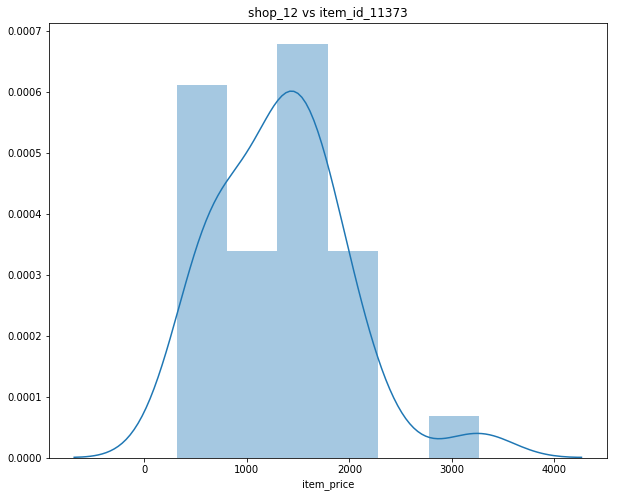

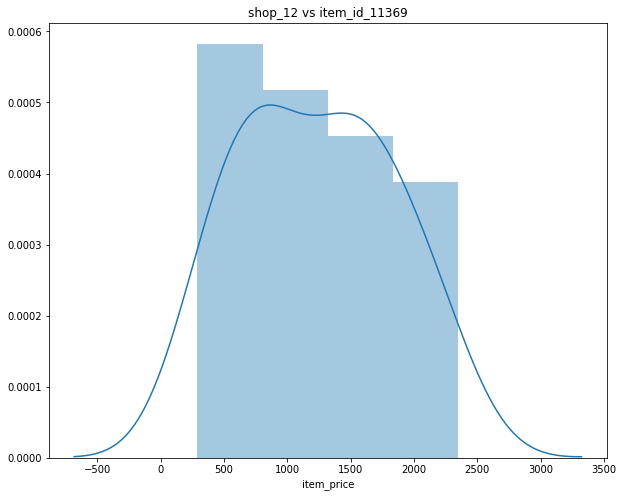

In [25]:
plt.figure(figsize=(10, 8))
sns.distplot(group[31][17717][22])
plt.xlabel('item_price')
plt.title("shop_12 vs item_id_11373")
plt.show()

plt.figure(figsize=(10, 8))
sns.distplot(group[31][17717][24])
plt.xlabel('item_price')
plt.title("shop_12 vs item_id_11369")     
plt.show()

In [11]:
sales_train.groupby(['shop_id', 'item_id'])['item_price'].nunique().sort_values(ascending=False)

shop_id  item_id
12       11373      427
         11369      344
         11370      335
31       17717      288
27       17717      229
42       17717      209
12       11365      207
7        17717      177
6        17717      173
12       13753      151
22       17717      149
4        17717      145
25       17717      135
24       17717      128
38       17717      126
28       17717      124
35       17717      119
26       17717      116
21       17717      112
47       17717      111
12       11372      106
54       17717      103
53       17717      103
46       17717      101
59       17717      100
48       17717       94
15       17717       94
16       17717       92
5        17717       89
43       17717       89
                   ... 
37       14079        1
         14058        1
         14086        1
         14087        1
         14088        1
         14091        1
         14094        1
         14095        1
         14098        1
         14060        1

In [12]:
group2 = sales_train.groupby(['shop_id', 'item_id'])['item_price'].unique()

In [13]:
group2.apply(len).sort_values(ascending=False)

shop_id  item_id
12       11373      427
         11369      344
         11370      335
31       17717      288
27       17717      229
42       17717      209
12       11365      207
7        17717      177
6        17717      173
12       13753      151
22       17717      149
4        17717      145
25       17717      135
24       17717      128
38       17717      126
28       17717      124
35       17717      119
26       17717      116
21       17717      112
47       17717      111
12       11372      106
54       17717      103
53       17717      103
46       17717      101
59       17717      100
48       17717       94
15       17717       94
16       17717       92
5        17717       89
43       17717       89
                   ... 
37       14079        1
         14058        1
         14086        1
         14087        1
         14088        1
         14091        1
         14094        1
         14095        1
         14098        1
         14060        1

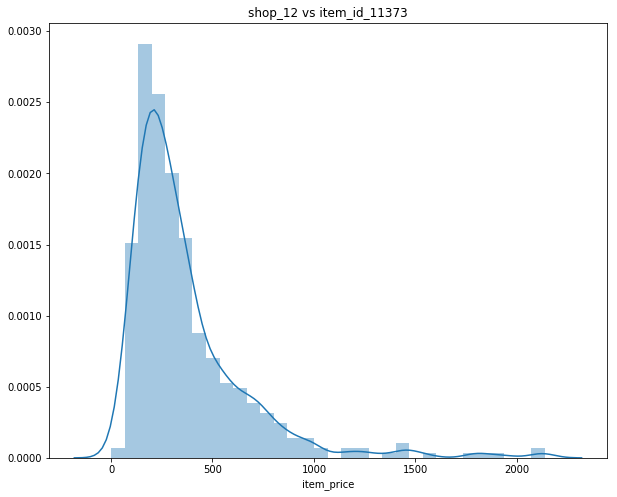

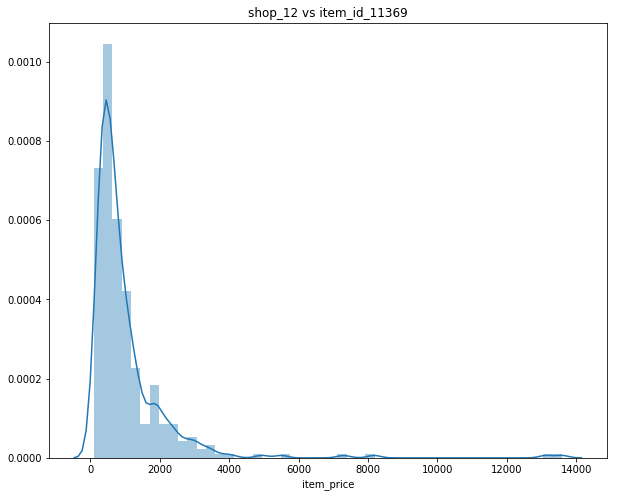

In [14]:
plt.figure(figsize=(10, 8))
sns.distplot(group2[12][11373])
plt.xlabel('item_price')
plt.title("shop_12 vs item_id_11373")
plt.show()

plt.figure(figsize=(10, 8))
sns.distplot(group2[12][11369])
plt.xlabel('item_price')
plt.title("shop_12 vs item_id_11369")     
plt.show()

In [15]:
group3 = sales_train.groupby('item_id')['item_price'].unique()

In [16]:
group3.apply(len).sort_values(ascending=False)

item_id
17717    1601
11373     427
11369     344
11370     335
6675      217
3732      215
11365     207
3731      198
1855      182
3734      166
13753     151
2445      147
4244      137
16787     129
7805      128
4248      127
3733      125
6498      123
3556      122
4249      121
6457      119
13405     115
6495      115
2814      112
6497      112
7070      111
11372     106
2308      106
8093      105
7982      104
         ... 
9302        1
9303        1
9306        1
9309        1
9310        1
9312        1
9317        1
9318        1
9324        1
9328        1
9329        1
9330        1
9331        1
9332        1
9333        1
9334        1
9335        1
9337        1
9338        1
9339        1
9349        1
9350        1
9351        1
9352        1
9354        1
9357        1
9360        1
9365        1
9368        1
0           1
Name: item_price, Length: 21807, dtype: int64

In [17]:
group4 = sales_train.groupby('shop_id')['item_price'].unique()

In [18]:
group4.apply(len).sort_values(ascending=False)

shop_id
31    3694
25    3241
51    3091
42    2695
28    2683
12    2524
27    2494
10    2482
35    2411
54    2346
6     2098
57    1918
22    1887
18    1810
21    1758
38    1750
26    1676
15    1631
46    1630
50    1601
7     1594
24    1592
47    1581
53    1467
19    1466
58    1451
16    1433
59    1428
56    1428
43    1411
30    1327
14    1320
41    1315
37    1274
45    1268
4     1258
29    1222
52    1203
5     1182
2     1114
44    1021
3     1021
48     939
17     881
13     870
39     813
49     782
0      621
34     540
55     519
1      485
9      475
32     406
33     379
23     333
11     274
8      214
20     185
40     172
36      87
Name: item_price, dtype: int64

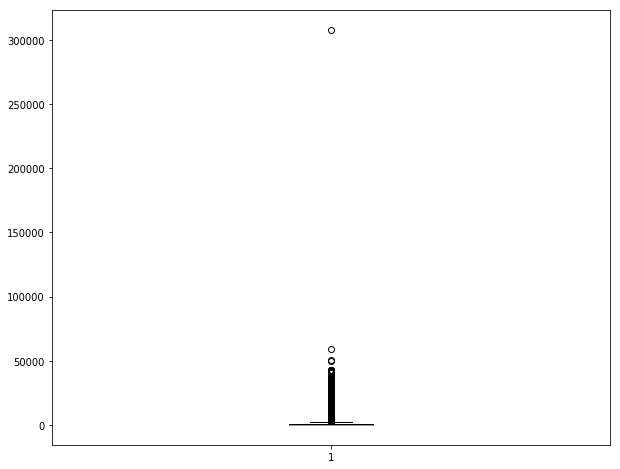

In [26]:
#item price outlier 
plt.figure(figsize=(10, 8))
plt.boxplot(sales_train.item_price)
plt.show()

In [31]:
sales_train[sales_train['item_price'] < ]["item_price"].count()

2935846

In [30]:
sales_train['item_price'].count()

2935849